In [23]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [196]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 12

In [30]:
def sample_transition(curr_state, t):
    p = pis*(1 - np.exp(-u*t))
    idx = curr_state.nonzero()[0][0]
    p[idx] = np.exp(-u*t) + p[idx]
    return np.eye(K)[np.random.choice(K, p=p)]

def compute_phenotype(geno, beta):
    return np.sum(geno*beta)

In [260]:
L = 10 # Number of loci
K = 2 # Number of alleles at each locus
pis = np.ones(K) / K # the stationary probabilities (uniform for now)
u = 1. / (1 - np.sum(pis**2))

beta = np.random.normal(scale=1, size=(L, K)) # Effect size for the each locus

In [315]:
def evolve_genotype(g_0, max_t=2., n_steps=1000):
    g_t = [g_0.copy()]
    for t in np.linspace(0, max_t, n_steps):
        g_t.append(np.zeros_like(g_t[-1]))
        for j in range(L):
            g_t[-1][j] = sample_transition(g_t[-2][j], max_t/n_steps)
    
    return g_t
    

In [387]:
def plot_genotype(gt, replicates=None, fig_file=None, expectation=False):
    plt.figure(figsize=(6, 4))
    fig, axs = plt.subplots(gt.shape[1],  sharex=True, sharey=False)

    x_labels = np.linspace(0, 3., gt.shape[0])

    for i in range(gt.shape[1]):
        if replicates is not None:
            for j in range(len(replicates)):
                axs[i].plot(x_labels, replicates[j][:, i], lw=.2, c='grey', alpha=0.3)
        axs[i].plot(x_labels, gt[:, i], lw=2.)
        axs[i].set_yticks([0.5])
        if expectation:
            axs[i].axhline(y=0.5, linewidth=.5, ls='--', zorder=0, color='grey', alpha=0.3)
            axs[i].set_yticklabels(['$E[X_{%d}(t)]$' % (i + 1)])
        else:
            axs[i].set_yticklabels(['$X_{%d}(t)$' % (i + 1)])
        axs[i].set_ylim(-0.3, 1.3)
        if i < L-1:
            axs[i].get_xaxis().set_visible(False)


    plt.xlabel("Time (ENS)")
    plt.locator_params(axis='x', nbins=10)
    plt.subplots_adjust(wspace=0, hspace=0)
    if fig_file is None:
        plt.show()
    else:
        plt.savefig(fig_file)
        
        
def plot_phenotype(gt, beta, fig_file=None):
    
    x_labels = np.linspace(0, 3., gt.shape[0])
    
    plt.figure(figsize=(6, 4))
    plt.plot(x_labels, [compute_phenotype(gt[i, :], beta[:, 1]) for i in range(gt.shape[0])])
    plt.xlabel("Time (ENS)")
    plt.ylabel("Mean Phenotype - $Z (t)$")
    plt.locator_params(axis='x', nbins=10)
    if fig_file is None:
        plt.show()
    else:
        plt.savefig(fig_file)

        
def plot_ensemble_moments(replicates, beta, mean_fig_file=None, var_fig_file=None):
    
    tt = replicates[0].shape[0]
    
    x_labels = np.linspace(0, 3., tt)
    
    z_t = np.zeros((len(replicates), tt))
    
    plt.figure(figsize=(6, 4))
    for j, r in enumerate(replicates):
        z_t[j] = np.array([compute_phenotype(r[i, :], beta[:, 1]) for i in range(tt)])
        plt.plot(x_labels, z_t[j],
                lw=.5, c='#E8E8E8')
        
    plt.plot(x_labels, z_t.mean(axis=0),
             lw=2.)
        
    plt.xlabel("Time (ENS)")
    plt.ylabel("Ensemble Mean - $E[Z (t)]$")
    plt.locator_params(axis='x', nbins=10)
    if mean_fig_file is None:
        plt.show()
    else:
        plt.savefig(mean_fig_file)
        
    plt.figure(figsize=(6, 4))
        
    plt.plot(x_labels, z_t.var(axis=0),
             lw=2.)
        
    plt.xlabel("Time (ENS)")
    plt.ylabel("Ensemble Variance - $Var[Z (t)]$")
    plt.locator_params(axis='x', nbins=10)
    
    if var_fig_file is None:
        plt.show()
    else:
        plt.savefig(var_fig_file)


# Evolution of mean phenotype with bi-allelic genetic architecture:

<Figure size 432x288 with 0 Axes>

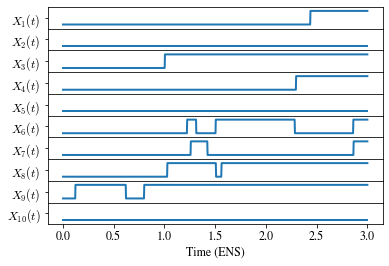

In [322]:
init_geno = np.eye(K)[np.zeros(L).astype(np.int)] # Initial genotype
g_t = evolve_genotype(init_geno)
g_t = np.array([np.where(g_t[i])[1] for i in range(len(g_t))])
plot_genotype(g_t)

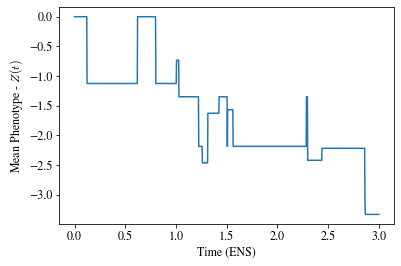

In [323]:
plot_phenotype(g_t, beta)

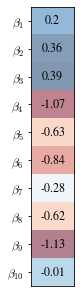

In [261]:
plt.figure(figsize=(1, 4))
plt.imshow(beta[:, 1:], cmap='RdBu', alpha=0.5, aspect='auto')
plt.xticks([])
plt.yticks(np.arange(L), ['$\\beta_{%d}$' % (i + 1) for i in range(L)])
for j in range(len(beta)):
    text = plt.text(0, j, np.round(beta[j, 1], 2),
                   ha="center", va="center", color="black")
plt.tight_layout(pad=0.2)
plt.savefig("./appendix_vis/fig1_b.svg")

# Moments of Mean Phenotype

In [376]:
n_replicates=100

#init_geno = np.eye(K)[np.random.choice(2, size=L, p=[0.9, 0.1]).astype(np.int)] # Initial genotype
init_geno = np.eye(K)[np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])]

res = []

for _ in  range(n_replicates):
    gt = evolve_genotype(init_geno)
    res.append(np.array([np.where(gt[i])[1] for i in range(len(gt))]))


<Figure size 432x288 with 0 Axes>

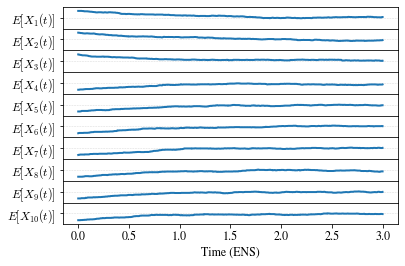

In [390]:
expected_genotype = np.zeros_like(res[0])
for i in range(n_replicates):
    expected_genotype += res[i]
    
plot_genotype(expected_genotype / n_replicates, fig_file="./appendix_vis/fig3a.svg", expectation=True)

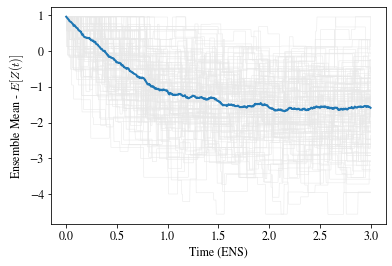

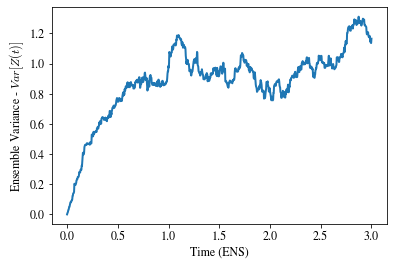

In [389]:
plot_ensemble_moments(res, beta, mean_fig_file="./appendix_vis/fig3b.svg", var_fig_file="./appendix_vis/fig3c.svg")

In [21]:
from Bio import Phylo
import pandas as pd
import numpy as np

tree = Phylo.read("/Users/szabad/geospiza.tree", "newick")
data = pd.read_csv("/Users/szabad/geospiza.dat", index_col=0)

In [123]:
nm = NeutralModel(data['beakD'], tree)
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': -5.608715915116547,
 'DOF': 5,
 'AIC': 21.217431830233096,
 'AIC.c': 31.217431830233096,
 'BIC': 23.641965079173097,
 'Parameters': {'Z0': 2.022322178438014,
  'Zeq': 1.8685537389997444,
  'Psi': 0.06713019030061128,
  'sigma_eq': 0.2998038681887233,
  'u': 1.8239396810783741}}

In [126]:
ou = OU(data['beakD'], tree, equilibrium_z0=True)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': -5.604653652198072,
 'DOF': 3,
 'AIC': 17.209307304396145,
 'AIC.c': 20.209307304396145,
 'BIC': 18.664027253760146,
 'Parameters': {'Zeq': 1.9183909990950805,
  'sigma': 0.9544306778726939,
  'alpha': 2.0265550004444206}}

In [125]:
bm = BM(data['beakD'], tree)
bm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'},
 'Loglikelihood': -6.037022935770681,
 'DOF': 2,
 'AIC': 16.07404587154136,
 'AIC.c': 17.407379204874694,
 'BIC': 17.04385917111736,
 'Parameters': {'Z0': 1.8331108917656214, 'sigma': 0.5834618372935301}}

In [55]:
data.describe()

,wingL,tarsusL,culmenL,beakD,gonysW
count,13.000000,13.000000,13.000000,13.000000,13.000000
mean,4.235734,2.991318,2.332751,2.082827,2.014043
std,0.118462,0.113506,0.232669,0.414684,0.326984
min,3.975393,2.806514,1.974420,1.191264,1.401186
25%,4.188600,2.929033,2.187000,1.941157,1.845379
50%,4.235020,2.980200,2.311100,2.073400,1.962100
75%,4.265425,3.038950,2.430250,2.347471,2.221867
max,4.419686,3.270543,2.724667,2.823767,2.675983


In [4]:
from gp_models.gp_models import *

nm = NeutralModel(data['beakD'], tree)
nm.fit_loco()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'MSE': array([2.29862744]), 'RMSE': array([1.5161225])}

In [6]:
nm = BM(data['beakD'], tree)
nm.fit_loco()

{'MSE': array([2.19506158]), 'RMSE': array([1.48157402])}

In [8]:
nm = OU(data['beakD'], tree)
nm.fit_loco()

{'MSE': array([2.55535798]), 'RMSE': array([1.59854871])}

In [136]:
data

,wingL,tarsusL,culmenL,beakD,gonysW
magnirostris,4.404200,3.038950,2.724667,2.823767,2.675983
conirostris,4.349867,2.984200,2.654400,2.513800,2.360167
difficilis,4.224067,2.898917,2.277183,2.011100,1.929983
scandens,4.261222,2.929033,2.621789,2.144700,2.036944
fortis,4.244008,2.894717,2.407025,2.362658,2.221867
fuliginosa,4.132957,2.806514,2.094971,1.941157,1.845379
pallida,4.265425,3.089450,2.430250,2.016350,1.949125
fusca,3.975393,2.936536,2.051843,1.191264,1.401186
parvulus,4.131600,2.973060,1.974420,1.873540,1.813340
pauper,4.232500,3.035900,2.187000,2.073400,1.962100


In [40]:
from gp_models.gp_models import NeutralModel, OU, BM
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
NeutralModel(data['beakD'], tree, fixed_params={'u': 1.37, 'Zeq': 3.5}).fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'},
 'Loglikelihood': -6.165366779905785,
 'DOF': 3,
 'AIC': 18.33073355981157,
 'AIC.c': 20.997400226478238,
 'BIC': 20.02558163219618,
 'Parameters': {'Z0': 0.029127152674909885,
  'Zeq': 3.5,
  'Psi': 1e-12,
  'sigma_eq': 0.76034782785505,
  'u': 1.37}}

In [19]:
erv_data = pd.read_csv("ancient_erv_analysis/data/3_q_traits/2_simulated_sequences/segment_7916_8695/traits.csv", index_col=0).T
erv_tree = Phylo.read("ancient_erv_analysis/metadata/segment_trees/paml_inferred/segment_7916_8695.nwk", "newick")

nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.37, 'Zeq': 0.36, 'sigma_eq': 0.000288})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 131.79868019120283,
 'DOF': 2,
 'AIC': -259.59736038240567,
 'AIC.c': -259.27303605808135,
 'BIC': -256.2196014741778,
 'Parameters': {'Z0': 0.45064921905129823,
  'Zeq': 0.36,
  'Psi': 0.001466726654975338,
  'sigma_eq': 0.000288,
  'u': 1.37}}

In [36]:
nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34, 'Zeq': 0.44, 'sigma_eq': 0.00031})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 133.3038790819269,
 'DOF': 2,
 'AIC': -262.6077581638538,
 'AIC.c': -262.2834338395295,
 'BIC': -259.22999925562596,
 'Parameters': {'Z0': 0.4286605308041588,
  'Zeq': 0.44,
  'Psi': 0.0013519381029283538,
  'sigma_eq': 0.00031,
  'u': 1.34}}

In [37]:
nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 134.25707429348367,
 'DOF': 4,
 'AIC': -260.51414858696734,
 'AIC.c': -259.37129144411017,
 'BIC': -253.7586307705116,
 'Parameters': {'Z0': 0.4297984876708193,
  'Zeq': 0.4359537231454264,
  'Psi': 9.99999997437784e-13,
  'sigma_eq': 0.0025563088548873187,
  'u': 1.34}}

In [38]:
nm = NeutralModel(erv_data['gc_content'], erv_tree)
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 134.90977876586916,
 'DOF': 5,
 'AIC': -259.8195575317383,
 'AIC.c': -258.0548516493854,
 'BIC': -251.37516026116865,
 'Parameters': {'Z0': 0.4298567820580272,
  'Zeq': 0.4341898649481175,
  'Psi': 9.999999960041972e-13,
  'sigma_eq': 0.0012508851221227223,
  'u': 2.0}}

In [41]:
ou = OU(erv_data['gc_content'], erv_tree)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 139.7563195304113,
 'DOF': 4,
 'AIC': -271.5126390608226,
 'AIC.c': -270.36978191796544,
 'BIC': -264.7571212443669,
 'Parameters': {'Z0': 0.4294136384780781,
  'Zeq': 0.4320629759227744,
  'sigma': 0.003293928936528404,
  'alpha': 18.468859845082363}}

In [44]:
ou = OU(erv_data['gc_content'], erv_tree, equilibrium_z0=True)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 139.7548962775069,
 'DOF': 3,
 'AIC': -273.5097925550138,
 'AIC.c': -272.8431258883471,
 'BIC': -268.443154192672,
 'Parameters': {'Zeq': 0.43201396720676144,
  'sigma': 0.003283819918767566,
  'alpha': 18.382295122779674}}

In [43]:
bm = BM(erv_data['gc_content'], erv_tree)
bm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 131.68912822706005,
 'DOF': 2,
 'AIC': -259.3782564541201,
 'AIC.c': -259.0539321297958,
 'BIC': -256.00049754589224,
 'Parameters': {'Z0': 0.43090571681745277, 'sigma': 0.0015004967278711004}}

In [27]:
1./(1. - (np.array([0.28,0.22,0.22,0.28])**2).sum())

1.339764201500536

In [35]:
(1./800)*.44*(1. - .44)

0.00030800000000000006

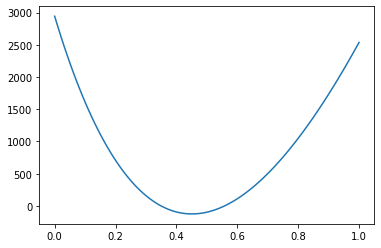

In [24]:
z0 = np.linspace(0., 1., 100)
L = 800

psi = (1./L)*(0.36 + z0 -2.*z0*0.36)

nll = []

for i in range(100):
    nm.z0 = z0[i]
    nm.psi = psi[i]
    nll.append(nm.nll())
    
plt.plot(z0, nll)

In [25]:
(1./L)*(0.36 + 0.45 -2.*0.45*0.36)

0.0006075000000000001

In [15]:
8695 - 7916

779

In [31]:
seq = "ACAGTTTGCTTGTCTTGAAGGGACAACAAAATACATTTACAGTTTTGCCCCAGGGCTATGTTAACTCTCTCACCCTCTGTCATAATACAGTCTGAAGAGATCTGGACCACCATGAGGACCTAGACATTCCACAGAATTACAGAACAACACACTGGTCCACTATATTGATGACATTGTGCTAATCAGACCAGATGAGCAAGAAATGACCAGCATACTGGAGGCCTTGGTAAGATACACGTGCTCCAAGGCATGGGTGATTAAATCCTACAAAGATACAGGGGCCTGCCATGTCAGTAAAGGTTTCTTTTAGGGGTCCCAGCAAGGGAGGCATATTAGCACAGAGGTCAAGAGAACAGTCCTTGGCTGTTCTCTGCCAAGCAAAGAGTAGGTGCTCAGAAATTGGGAGTTAATGTGATTATGGTACTGATGATAATTATAACTTTTGGAGTTTGGAAGACCTGGCCCTGCATCTGCTGTTAACCTGCCCATGTCTTTAAGTCATTAACTTTGTTAATGCCATGTGGCAATATGATGCCTTGGATTTCGAATACTGGAGCTTGATCAGAATGTTGGCTCTGCCCCCTTAGTGGTTGTGAAACCCTGAGCATGTTATTTCACATCTCTCTGAAATATGTATATTTTCTCCCCTGTTAATGATCACTTTGGATTAGATAATATCTAAAATATCTTCCATCTTGAATCTCCATAACTGCGTGTACTCCATGTGCAGTCTATGGTAGCTACCTACGCCACATGTGGCTATTTAAACTTACCCTCACA"

(seq.count("C") + seq.count("G"))  / len(seq)

0.4256410256410256

In [48]:
with open("ancient_erv_analysis/data/2_simulated_sequences/segment_8938_9248/alignment.root", "rb") as f:
    root_seq = str(f.read()).strip()
    print(root_seq.count("C"))
    

52


In [49]:
.44*(1.-.44)

0.24640000000000004